In [1]:
# Install and import the necessary libraries
!pip install -q -U torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops evaluate
!pip install -q -U tqdm
!pip install -q -U git+https://github.com/sissa-data-science/DADApy

In [2]:
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.2 MB/s eta 0:00:00


In [2]:
import os
import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
    DistilBertModel,
    DistilBertTokenizer,
)
from tqdm import tqdm
from trl import SFTTrainer
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np
# import skdim

2024-06-14 14:39:16.827186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 14:39:16.827286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 14:39:16.955528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set device
torch.set_default_device("cuda")

# Load pre-trained model and tokenizer
model_name = "distilbert/distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name,
                                          add_eos_token=True,
                                          trust_remote_code=True)

tokenizer.pad_token = '[PAD]'
tokenizer.truncation_side = "right"

# Load dataset
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split="train[:4500]")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31232 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5206 [00:00<?, ? examples/s]

In [4]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
          padding='max_length',
        ).to("cuda")


    return encoded

In [5]:
# Applying tokenization to the dataset
tokenized_dataset = dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["id", "text", "label", "sentiment"])

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [6]:
model = DistilBertModel.from_pretrained(model_name, device_map="cuda")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## batch size = 10

In [8]:
# computing intrinsic dimentions
# Constants

torch.cuda.empty_cache()
gc.collect()

# total samples
num_data = 4500

batches = 10

# samples per batch
batch_data = num_data//batches

# Samples per sub-batch within each batch
per_batch = batch_data//batches

# Number of sub-batches per batch
number_batches = batch_data // per_batch

# initializing intrinsic dimension and error lists for each batch
intrinsic_dims = [[] for _ in range(batches)]
intrinsic_dims_errors = [[] for _ in range(batches)]

for x in range(batches):
  torch.set_default_device("cuda")

  # Collect hidden layers
  hidden_layers = []

  # Collect hidden layers per batch
  for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
      # Extract inputs from the dataset using the tokenizer
      index = batch * per_batch + i + x * batch_data
      inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[index].items()}

      # Perform forward pass through the model
      with torch.no_grad():
          outputs = model(**inputs, output_hidden_states=True)

      # Append the hidden states to the list
      liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
      hidden_layers.append(liste)
      del outputs, liste, inputs
      torch.cuda.empty_cache()
      gc.collect()


  # Move back to CPU
  torch.set_default_device("cpu")

  # Process hidden layers
  hidden_layers_avg = []
  n = len(hidden_layers[0])
  for j in range(n):
      avg_batch_layer = []
      for i in range(number_batches * per_batch):
          layer = hidden_layers[i][j].detach().cpu()
          avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
      hidden_layers_avg.append(avg_batch_layer)

  # Handle empty tensors
  for layer in hidden_layers_avg:
      for idx, tensor in enumerate(layer):
          if tensor.shape == torch.Size([]):
              print("Encountered empty tensor. Filling with zeros.")
              layer[idx] = torch.zeros(2560)


  # Stack hidden layers
  hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
  hidden_layers_stacked = torch.stack(hidden_layers_stacked)

  del hidden_layers, hidden_layers_avg
  gc.collect()

  # Compute intrinsic dimensions
  for i in range(n):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
    intrinsic_dims[x].append(id_list_2NN[1])
    intrinsic_dims_errors[x].append(error_list_2NN[1])
    
    # 2NN ID Estimator
#     data = Data(X)
#     data.remove_identical_points()
#     id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN()
#     min_error_index = np.argmin(error_list_2NN)
#     selected_id = id_list_2NN[min_error_index] 
#     intrinsic_dims[x].append(selected_id)
#     intrinsic_dims_errors[x].append(error_list_2NN[min_error_index])

    # KNN ID Estimator
#     knn_estimator = skdim.id.KNN()
#     id_estimate = knn_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # 2NN ID Estimator
#     nn_estimator = skdim.id.TwoNN()
#     id_estimate = nn_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # MLE ID Estimator
#     mle_estimator = skdim.id.MLE()
#     id_estimate = mle_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # ESS ID Estimator
#     ess_estimator = skdim.id.ESS()
#     id_estimate = ess_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # FisherS ID Estimator
#     fisherS_estimator = skdim.id.FisherS()
#     id_estimate = fisherS_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # Correlation Dimension ID Estimator
#     corrInt_estimator = skdim.id.CorrInt()
#     id_estimate = corrInt_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

    # TLE ID Estimator
#     tle_estimator = skdim.id.TLE()
#     id_estimate = tle_estimator.fit_transform(X)
#     intrinsic_dims[x].append(id_estimate)

100%|██████████| 10/10 [02:56<00:00, 17.62s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:53<00:00, 17.38s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:54<00:00, 17.44s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:52<00:00, 17.28s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:51<00:00, 17.19s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:51<00:00, 17.10s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:50<00:00, 17.03s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


100%|██████████| 10/10 [02:49<00:00, 16.95s/it]


No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


In [29]:
intrinsic_dims

[[16.362748478773884,
  15.51775976808943,
  14.440547153486127,
  14.836788614543336,
  17.419281576355502,
  18.014618070342927,
  17.200184160157303],
 [16.97292906195604,
  16.056309865616264,
  15.127049681744552,
  14.92999789224673,
  18.456848439679842,
  19.4387091116293,
  18.38059785999056],
 [16.237748807639502,
  15.500819802548781,
  15.100433440643785,
  15.092650891001998,
  17.90499120715863,
  19.26642848259625,
  17.86252832502019]]

In [30]:
# calculating mean and standard deviation of intrinsic dimensions for each layer
mean = np.mean(intrinsic_dims, axis=0)
std = np.std(intrinsic_dims, axis=0)

In [31]:
mean

array([16.52, 15.69, 14.89, 14.95, 17.93, 18.91, 17.81])

In [32]:
std

array([0.32, 0.26, 0.32, 0.11, 0.42, 0.63, 0.48])

## Calculating weighted mean and std

In [9]:
# calculating weighted mean and standard deviation of intrinsic dimensions for each layer
weighted_mean = np.average(intrinsic_dims, axis=0, weights=intrinsic_dims_errors) # avg = sum(a * weights) / sum(weights)

In [10]:
weighted_mean

array([26.01, 20.54, 20.18, 21.37, 24.56, 26.1 , 24.95])

In [11]:
n = len(intrinsic_dims[0]) # number of layers
weighted_std = []

for i in range(n):
    weighted_sum_of_diff = 0
    error_sum = 0
    
    for j in range(len(intrinsic_dims)):
        weighted_sum_of_diff += intrinsic_dims_errors[j][i] * (intrinsic_dims[j][i]- weighted_mean[i])**2
        error_sum += intrinsic_dims_errors[j][i]
        
    # Number of non-zero errors for this layer
    m = sum(1 for error in intrinsic_dims_errors if error[i] != 0)

    den = ((m-1) * error_sum)/m
    layer_weighted_std = np.sqrt(weighted_sum_of_diff/den)
    weighted_std.append(layer_weighted_std)

In [12]:
weighted_std

[1.4630636939650934,
 1.315182663782254,
 0.8846166807256974,
 0.9925263510167898,
 1.1056534615162745,
 1.200140724590869,
 1.2695196765112629]

## batch size = 4

In [ ]:
# computing intrinsic dimentions
# Constants

torch.cuda.empty_cache()
gc.collect()

# total samples
num_data = 4500

batches = 4

# samples per batch
batch_data = num_data//batches

# Samples per sub-batch within each batch
per_batch = batch_data//batches

# Number of sub-batches per batch
number_batches = batch_data // per_batch

# initializing intrinsic dimension and error lists for each batch
intrinsic_dims = [[] for _ in range(batches)]
intrinsic_dims_errors = [[] for _ in range(batches)]

for x in range(batches):
  torch.set_default_device("cuda")

  # Collect hidden layers
  hidden_layers = []

  # Collect hidden layers per batch
  for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
      # Extract inputs from the dataset using the tokenizer
      index = batch * per_batch + i + x * batch_data
      inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[index].items()}

      # Perform forward pass through the model
      with torch.no_grad():
          outputs = model(**inputs, output_hidden_states=True)

      # Append the hidden states to the list
      liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
      hidden_layers.append(liste)
      del outputs, liste, inputs
      torch.cuda.empty_cache()
      gc.collect()


  # Move back to CPU
  torch.set_default_device("cpu")

  # Process hidden layers
  hidden_layers_avg = []
  n = len(hidden_layers[0])
  for j in range(n):
      avg_batch_layer = []
      for i in range(number_batches * per_batch):
          layer = hidden_layers[i][j].detach().cpu()
          avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
      hidden_layers_avg.append(avg_batch_layer)

  # Handle empty tensors
  for layer in hidden_layers_avg:
      for idx, tensor in enumerate(layer):
          if tensor.shape == torch.Size([]):
              print("Encountered empty tensor. Filling with zeros.")
              layer[idx] = torch.zeros(2560)


  # Stack hidden layers
  hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
  hidden_layers_stacked = torch.stack(hidden_layers_stacked)

  del hidden_layers, hidden_layers_avg
  gc.collect()

  # Compute intrinsic dimensions
  for i in range(n):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN()
    min_error_index = np.argmin(error_list_2NN[1:])  
    selected_id = id_list_2NN[min_error_index] 
    intrinsic_dims[x].append(selected_id)
    intrinsic_dims_errors[x].append(error_list_2NN[min_error_index])

In [ ]:
# calculating mean and standard deviation of intrinsic dimensions for each layer
mean = np.mean(intrinsic_dims, axis=0)
std = np.std(intrinsic_dims, axis=0)

In [ ]:
mean

In [ ]:
std

## Calculating weighted mean and std

In [ ]:
# calculating weighted mean and standard deviation of intrinsic dimensions for each layer
weighted_mean = np.average(intrinsic_dims, axis=0, weights=intrinsic_dims_errors) # avg = sum(a * weights) / sum(weights)

In [ ]:
weighted_mean

In [ ]:
n = len(intrinsic_dims[0]) # number of layers
weighted_std = []

for i in range(n):
    weighted_sum_of_diff = 0
    error_sum = 0
    
    for j in range(len(intrinsic_dims)):
        weighted_sum_of_diff += intrinsic_dims_errors[j][i] * (intrinsic_dims[j][i]- weighted_mean[i])**2
        error_sum += intrinsic_dims_errors[j][i]
        
    # Number of non-zero errors for this layer
    m = sum(1 for error in intrinsic_dims_errors if error[i] != 0)

    den = ((m-1) * error_sum)/m
    layer_weighted_std = np.sqrt(weighted_sum_of_diff/den)
    weighted_std.append(layer_weighted_std)

In [ ]:
weighted_std

## Graph for Confidence Interval

In [13]:
true = np.array([28.578906401758985, 23.301498269969102, 23.89740506371369,23.635757291150483, 27.106722449881055, 27.619642315202356, 26.124813219360163 ])
mean_id = np.array([26.01, 20.54, 20.18, 21.37, 24.56, 26.1 , 24.95])
std_id = np.array([1.4630636939650934,
 1.315182663782254,
 0.8846166807256974,
 0.9925263510167898,
 1.1056534615162745,
 1.200140724590869,
 1.2695196765112629])

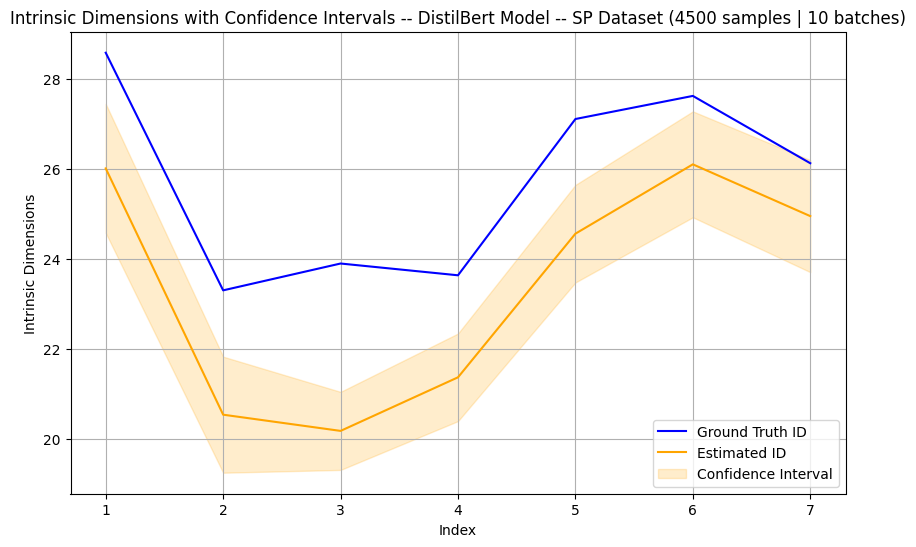

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 8),true, label="Ground Truth ID", color='blue')
plt.plot(range(1, 8), mean_id, label="Estimated ID", color='orange')


# Adding confidence intervals
plt.fill_between(range(1, 8), mean_id - 1.96*std_id/(4**0.5), mean_id + 1.96*std_id/(4**0.5), color='orange', alpha=0.2, label='Confidence Interval')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Intrinsic Dimensions')
plt.legend(loc='best')
plt.title('Intrinsic Dimensions with Confidence Intervals -- DistilBert Model -- SP Dataset (4500 samples | 10 batches)')
plt.grid(True)
plt.show()
plt.savefig("distilbert_sbatches.png")



In [39]:
true = np.array([28.578906401758985, 23.301498269969102, 23.89740506371369,23.635757291150483, 27.106722449881055, 27.619642315202356, 26.124813219360163 ])
mean_id = np.array([28.59, 23.76, 23.51, 23.27, 26.96, 27.99, 26.42])
std_id = np.array([0.9836200635151802,
 0.6549659104359925,
 1.468359366499873,
 0.22574376466411236,
 0.9504137512505502,
 0.6781913174330599,
 0.7158390084495714])

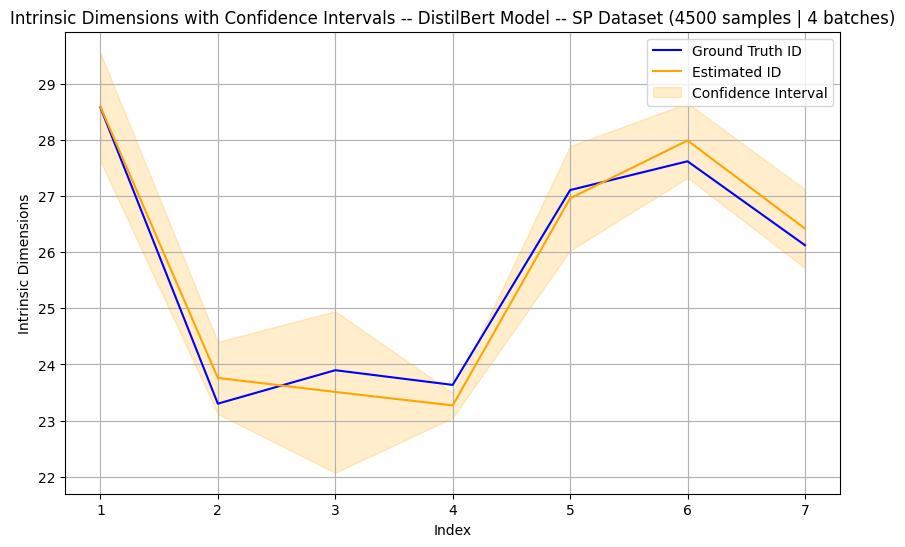

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 8),true, label="Ground Truth ID", color='blue')
plt.plot(range(1, 8), mean_id, label="Estimated ID", color='orange')


# Adding confidence intervals
plt.fill_between(range(1, 8), mean_id - 1.96*std_id/(4**0.5), mean_id + 1.96*std_id/(4**0.5), color='orange', alpha=0.2, label='Confidence Interval')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Intrinsic Dimensions')
plt.legend(loc='best')
plt.title('Intrinsic Dimensions with Confidence Intervals -- DistilBert Model -- SP Dataset (4500 samples | 4 batches)')
plt.grid(True)
plt.show()
plt.savefig("distilbert_sbatches.png")



## Intrinsic Dimension Profile of Different ID Estimates

In [18]:
id_2nn_scale_nobatch = [25.783684711530256,
22.862326971615232,
21.83180717509225,
21.63306150660067,
25.56115256440055,
26.465031360283753,
25.521369064933594]
mean_id_2nn_scale = [27.99,
22.52,
23.82,
22.31,
26.18,
27.3,
24.95]
mean_id_knn = [2.,
3.33,
5.33,
6.33,
2.67,
5.67]
mean_id_mle = [19.67,
18.18,
16.55,
16.68,
20.54,
22.24,
21.3]
mean_id_2NN = [27.72,
22.3,
23.59,
22.09,
25.93,
27.03,
24.7] 
mean_id_ess = [15.38,
29.66,
25.13,
26.72,
38.41,
44.01,
43.83]
mean_id_fs = [0.87,
5.66,
3.86,
3.66,
5.73,
8.32,
10.74]
mean_id_corrInt = [3.62,
10.81,
10.82,
10.81,
12.64,
12.67,
11.86] 
mean_id_tle = [16.52,
15.69,
14.89,
14.95,
17.93,
18.91,
17.81]

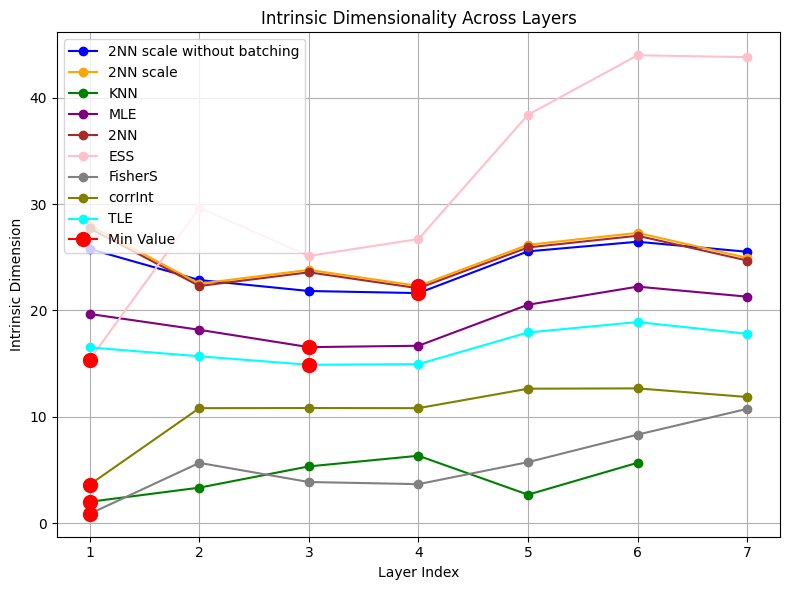

In [22]:
# Plot results
# Find the index of the minimum value
min_index_1 = id_2nn_scale_nobatch.index(min(id_2nn_scale_nobatch)) + 1
min_index_2 = mean_id_2nn_scale.index(min(mean_id_2nn_scale)) + 1
min_index_3 = mean_id_knn.index(min(mean_id_knn)) + 1
min_index_4 = mean_id_mle.index(min(mean_id_mle)) + 1
min_index_5 = mean_id_2NN.index(min(mean_id_2NN)) + 1
min_index_6 = mean_id_ess.index(min(mean_id_ess)) + 1
min_index_7 = mean_id_fs.index(min(mean_id_fs)) + 1
min_index_8 = mean_id_corrInt.index(min(mean_id_corrInt)) + 1
min_index_9 = mean_id_tle.index(min(mean_id_tle)) + 1


# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 8), id_2nn_scale_nobatch, marker='o', linestyle='-', label='2NN scale without batching', color='blue')
plt.plot(min_index_1, min(id_2nn_scale_nobatch), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_2nn_scale, marker='o', linestyle='-', label='2NN scale', color='orange')
plt.plot(min_index_2, min(mean_id_2nn_scale), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 7), mean_id_knn, marker='o', linestyle='-', label='KNN',color='green')
plt.plot(min_index_3, min(mean_id_knn), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_mle, marker='o', linestyle='-', label='MLE',color='purple')
plt.plot(min_index_4, min(mean_id_mle), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
plt.plot(min_index_5, min(mean_id_2NN), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_ess, marker='o', linestyle='-', label='ESS',color='pink')
plt.plot(min_index_6, min(mean_id_ess), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
plt.plot(min_index_7, min(mean_id_fs), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
plt.plot(min_index_8, min(mean_id_corrInt), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
plt.plot(min_index_9, min(mean_id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 8))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()

## Running trials for all ID estimators

In [8]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
        knn_estimator = skdim.id.KNN()
        id_estimate = knn_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
    print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [06:20<00:00,  9.51s/it]


Intrinsic Dimensions for trial 0 is  [768, 2, 6, 1, 4, 3, 768]


100%|██████████| 40/40 [06:14<00:00,  9.37s/it]


Intrinsic Dimensions for trial 1 is  [768, 17, 7, 1, 58, 9, 768]


100%|██████████| 40/40 [06:13<00:00,  9.34s/it]


Intrinsic Dimensions for trial 2 is  [1, 4, 2, 10, 2, 2, 768]


100%|██████████| 40/40 [06:13<00:00,  9.33s/it]


Intrinsic Dimensions for trial 3 is  [1, 5, 768, 3, 9, 5, 11]


100%|██████████| 40/40 [06:14<00:00,  9.36s/it]


Intrinsic Dimensions for trial 4 is  [768, 9, 3, 2, 6, 768, 21]


100%|██████████| 40/40 [06:13<00:00,  9.33s/it]


Intrinsic Dimensions for trial 5 is  [768, 768, 9, 768, 13, 2, 2]


100%|██████████| 40/40 [06:11<00:00,  9.28s/it]


Intrinsic Dimensions for trial 6 is  [1, 5, 4, 3, 2, 6, 25]


100%|██████████| 40/40 [06:12<00:00,  9.31s/it]


Intrinsic Dimensions for trial 7 is  [1, 768, 768, 6, 10, 4, 17]


100%|██████████| 40/40 [06:06<00:00,  9.16s/it]


Intrinsic Dimensions for trial 8 is  [7, 1, 768, 4, 6, 8, 4]


100%|██████████| 40/40 [06:06<00:00,  9.17s/it]


Intrinsic Dimensions for trial 9 is  [1, 5, 2, 7, 8, 2, 8]


In [9]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        mle_estimator = skdim.id.MLE()
        id_estimate = mle_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
    print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [06:05<00:00,  9.15s/it]


Intrinsic Dimensions for trial 0 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [06:02<00:00,  9.07s/it]


Intrinsic Dimensions for trial 1 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [06:03<00:00,  9.09s/it]


Intrinsic Dimensions for trial 2 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [06:04<00:00,  9.12s/it]


Intrinsic Dimensions for trial 3 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [06:05<00:00,  9.14s/it]


Intrinsic Dimensions for trial 4 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [05:57<00:00,  8.94s/it]


Intrinsic Dimensions for trial 5 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [05:53<00:00,  8.84s/it]


Intrinsic Dimensions for trial 6 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [05:45<00:00,  8.65s/it]


Intrinsic Dimensions for trial 7 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [05:37<00:00,  8.45s/it]


Intrinsic Dimensions for trial 8 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


100%|██████████| 40/40 [05:34<00:00,  8.37s/it]


Intrinsic Dimensions for trial 9 is  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]


In [10]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        fisherS_estimator = skdim.id.FisherS()
        id_estimate = fisherS_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
    print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [05:42<00:00,  8.57s/it]


Intrinsic Dimensions for trial 0 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:14<00:00,  9.37s/it]


Intrinsic Dimensions for trial 1 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:17<00:00,  9.44s/it]


Intrinsic Dimensions for trial 2 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:24<00:00,  9.61s/it]


Intrinsic Dimensions for trial 3 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:23<00:00,  9.59s/it]


Intrinsic Dimensions for trial 4 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:31<00:00,  9.79s/it]


Intrinsic Dimensions for trial 5 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:25<00:00,  9.64s/it]


Intrinsic Dimensions for trial 6 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:22<00:00,  9.56s/it]


Intrinsic Dimensions for trial 7 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:12<00:00,  9.32s/it]


Intrinsic Dimensions for trial 8 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


100%|██████████| 40/40 [06:06<00:00,  9.15s/it]


Intrinsic Dimensions for trial 9 is  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]


In [11]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        corrInt_estimator = skdim.id.CorrInt()
        id_estimate = corrInt_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
    print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [06:06<00:00,  9.16s/it]


Intrinsic Dimensions for trial 0 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:06<00:00,  9.16s/it]


Intrinsic Dimensions for trial 1 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:17<00:00,  9.44s/it]


Intrinsic Dimensions for trial 2 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:15<00:00,  9.38s/it]


Intrinsic Dimensions for trial 3 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:25<00:00,  9.64s/it]


Intrinsic Dimensions for trial 4 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:28<00:00,  9.72s/it]


Intrinsic Dimensions for trial 5 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:28<00:00,  9.72s/it]


Intrinsic Dimensions for trial 6 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:31<00:00,  9.78s/it]


Intrinsic Dimensions for trial 7 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:31<00:00,  9.78s/it]


Intrinsic Dimensions for trial 8 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


100%|██████████| 40/40 [06:30<00:00,  9.75s/it]


Intrinsic Dimensions for trial 9 is  [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]


In [12]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        tle_estimator = skdim.id.TLE()
        id_estimate = tle_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)
    print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [06:32<00:00,  9.82s/it]


Intrinsic Dimensions for trial 0 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:34<00:00,  9.85s/it]


Intrinsic Dimensions for trial 1 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:34<00:00,  9.87s/it]


Intrinsic Dimensions for trial 2 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:33<00:00,  9.84s/it]


Intrinsic Dimensions for trial 3 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:36<00:00,  9.91s/it]


Intrinsic Dimensions for trial 4 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:37<00:00,  9.93s/it]


Intrinsic Dimensions for trial 5 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:37<00:00,  9.93s/it]


Intrinsic Dimensions for trial 6 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:37<00:00,  9.93s/it]


Intrinsic Dimensions for trial 7 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:35<00:00,  9.88s/it]


Intrinsic Dimensions for trial 8 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


100%|██████████| 40/40 [06:31<00:00,  9.80s/it]


Intrinsic Dimensions for trial 9 is  [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]


In [13]:
import torch
import gc
from tqdm import tqdm
import skdim

trials = 10
intrinsic_dims = []
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
#     intrinsic_dims = []
    nn_estimator = skdim.id.TwoNN()
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # Example using TwoNN ID Estimator
        id_estimate = nn_estimator.fit_transform(X)
        intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
        # ess_estimator = skdim.id.ESS()
        # id_estimate = ess_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
#     print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)


100%|██████████| 40/40 [06:29<00:00,  9.74s/it]


Intrinsic Dimensions for trial 0 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:27<00:00,  9.69s/it]


Intrinsic Dimensions for trial 1 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:28<00:00,  9.71s/it]


Intrinsic Dimensions for trial 2 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:27<00:00,  9.69s/it]


Intrinsic Dimensions for trial 3 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:26<00:00,  9.67s/it]


Intrinsic Dimensions for trial 4 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:28<00:00,  9.71s/it]


Intrinsic Dimensions for trial 5 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:30<00:00,  9.76s/it]


Intrinsic Dimensions for trial 6 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:31<00:00,  9.78s/it]


Intrinsic Dimensions for trial 7 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:25<00:00,  9.65s/it]


Intrinsic Dimensions for trial 8 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


100%|██████████| 40/40 [06:26<00:00,  9.67s/it]


Intrinsic Dimensions for trial 9 is  [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]


## Density Calculation

In [21]:
import torch
import gc
from tqdm import tqdm
# import skdim

trials = 1
for trial in range(trials):
    # Constants
    torch.cuda.empty_cache()
    gc.collect()
    num_data = 1000
    per_batch = 25
    number_batches = num_data // per_batch

    # Collect hidden layers
    hidden_layers = []

    # Collect hidden layers per batch
    for batch in tqdm(range(number_batches)):
        for i in range(per_batch):
            # Extract inputs from the dataset using the tokenizer
            inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

            # Perform forward pass through the model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)

            # Append the hidden states to the list
            liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
            hidden_layers.append(liste)
            del outputs, liste, inputs
            torch.cuda.empty_cache()
            gc.collect()
    
    # Move back to CPU
    torch.set_default_device("cpu")

    # Process hidden layers
    hidden_layers_avg = []
    n = len(hidden_layers[0])
    for j in range(n):
        avg_batch_layer = []
        for i in range(number_batches * per_batch):
            layer = hidden_layers[i][j].detach().cpu()
            avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
        hidden_layers_avg.append(avg_batch_layer)

    # Handle empty tensors
    for layer in hidden_layers_avg:
        for idx, tensor in enumerate(layer):
            if tensor.shape == torch.Size([]):
                print("Encountered empty tensor. Filling with zeros.")
                layer[idx] = torch.zeros(2560)

    # Stack hidden layers
    hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
    hidden_layers_stacked = torch.stack(hidden_layers_stacked)

    del hidden_layers, hidden_layers_avg
    gc.collect()

    # Compute intrinsic dimensions
    intrinsic_dims = []
    density = []
    density_error = []
    for i in range(n):
        X = hidden_layers_stacked[i].numpy()
        
        # density estimation
        data = Data(X)
        for j in range(1,31):
            log_den, log_den_error = data.compute_density_kNN(k=j)
            density.append(log_den)
            density_error.append(density_error)
        
        # Example using TwoNN ID Estimator
#         nn_estimator = skdim.id.TwoNN()
#         id_estimate = nn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # 2NN ID Estimator
        # data = Data(X)
        # data.remove_identical_points()
        # id_list_2NN, error_list_2NN, _ = data.return_id_scaling_2NN() 
        # intrinsic_dims.append(id_list_2NN[1])

        # KNN ID Estimator
#         knn_estimator = skdim.id.KNN()
#         id_estimate = knn_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # MLE ID Estimator
        # mle_estimator = skdim.id.MLE()
        # id_estimate = mle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # ESS ID Estimator
#         ess_estimator = skdim.id.ESS()
#         id_estimate = ess_estimator.fit_transform(X)
#         intrinsic_dims.append(id_estimate)

        # FisherS ID Estimator
        # fisherS_estimator = skdim.id.FisherS()
        # id_estimate = fisherS_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # Correlation Dimension ID Estimator
        # corrInt_estimator = skdim.id.CorrInt()
        # id_estimate = corrInt_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)

        # TLE ID Estimator
        # tle_estimator = skdim.id.TLE()
        # id_estimate = tle_estimator.fit_transform(X)
        # intrinsic_dims.append(id_estimate)
#     print(f"Intrinsic Dimensions for trial {trial} is ",intrinsic_dims)

100%|██████████| 40/40 [05:24<00:00,  8.10s/it]


In [22]:
# 10 K values for each of the 7 layers
len(density)

210

In [23]:
# density[0..10] - k values for 1st layer
density[0][999]

38.43423717075554

In [24]:
# Organize the density data into a 2D array for mean values (7 layers x 10 k values)
mean_density = np.zeros((7, 30))

index = 0
for i in range(7):  # for each layer
    for j in range(30):  # for each k value
        # Calculate the mean density for the current layer and k value
        mean_density[i, j] = np.mean(density[index])
        index += 1

In [25]:
mean_density

array([[ 35.19,  34.78,  34.64,  34.52,  34.46,  34.4 ,  34.3 ,  34.25,
         34.2 ,  34.14,  34.09,  34.05,  34.  ,  33.96,  33.92,  33.88,
         33.84,  33.8 ,  33.76,  33.73,  33.69,  33.65,  33.61,  33.56,
         33.52,  33.48,  33.45,  33.41,  33.38,  33.34],
       [ -7.81,  -8.17,  -8.27,  -8.32,  -8.38,  -8.42,  -8.46,  -8.49,
         -8.52,  -8.55,  -8.57,  -8.6 ,  -8.63,  -8.65,  -8.67,  -8.69,
         -8.71,  -8.74,  -8.76,  -8.78,  -8.8 ,  -8.82,  -8.85,  -8.87,
         -8.89,  -8.92,  -8.93,  -8.95,  -8.97,  -8.99],
       [-24.67, -25.01, -25.18, -25.3 , -25.4 , -25.48, -25.56, -25.61,
        -25.67, -25.73, -25.79, -25.84, -25.88, -25.93, -25.97, -26.01,
        -26.05, -26.08, -26.11, -26.14, -26.18, -26.22, -26.25, -26.29,
        -26.33, -26.36, -26.39, -26.42, -26.45, -26.49],
       [-30.53, -30.89, -31.08, -31.18, -31.26, -31.35, -31.42, -31.48,
        -31.53, -31.59, -31.63, -31.67, -31.71, -31.75, -31.8 , -31.83,
        -31.87, -31.9 , -31.94, -31.9

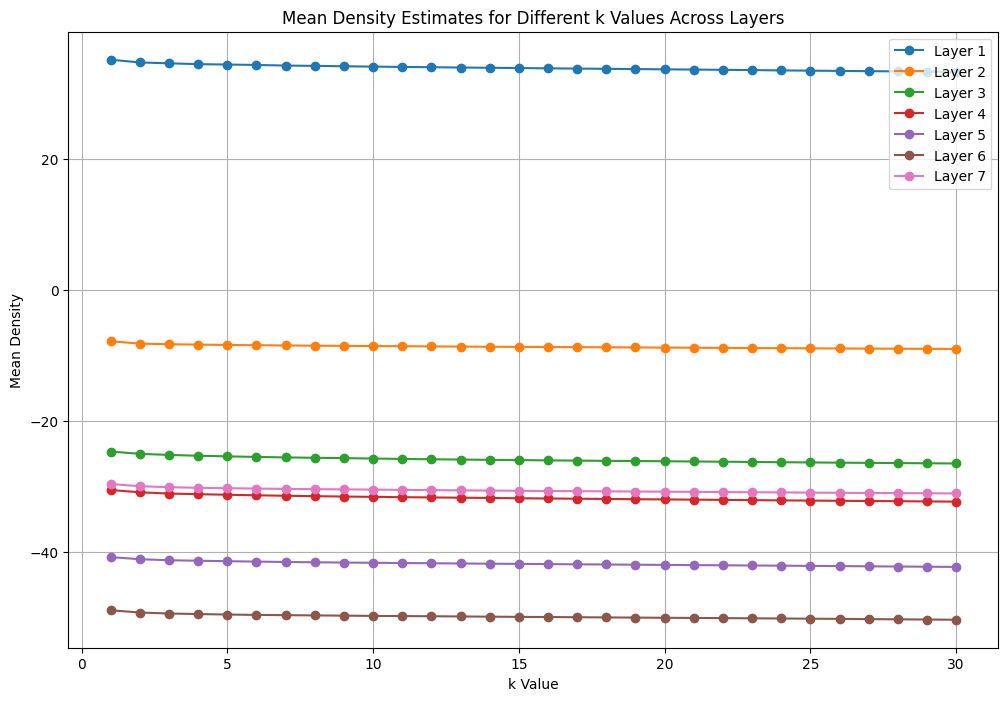

In [27]:
# Plot the mean density values for each layer
plt.figure(figsize=(12, 8))

for i in range(7):
    plt.plot(range(1, 31), mean_density[i], marker='o', linestyle='-', label=f'Layer {i+1}')

plt.xlabel('k Value')
plt.ylabel('Mean Density')
plt.title('Mean Density Estimates for Different k Values Across Layers')
plt.legend()
plt.grid(True)
plt.show()

## Plotting ID profiles for different ID estimators

In [1]:
knn_ids = [ [768, 2, 6, 1, 4, 3, 768], [768, 17, 7, 1, 58, 9, 768], [1, 4, 2, 10, 2, 2, 768],[1, 5, 768, 3, 9, 5, 11],[768, 9, 3, 2, 6, 768, 21],  [768, 768, 9, 768, 13, 2, 2], [1, 5, 4, 3, 2, 6, 25],  [1, 768, 768, 6, 10, 4, 17], [7, 1, 768, 4, 6, 8, 4], [1, 5, 2, 7, 8, 2, 8]]

In [3]:
import numpy as np

In [5]:
# calculating mean and standard deviation of intrinsic dimensions for each layer
mean = np.mean(knn_ids, axis=0)
std = np.std(knn_ids, axis=0)

In [6]:
mean

array([308.4, 158.4, 233.7,  80.5,  11.8,  80.9, 239.2])

In [7]:
std

array([375.26582578, 304.82919808, 349.78766416, 229.18256915,
        15.75309493, 229.04560681, 346.24638626])

In [9]:
mean_id_2NN = [29.233686569019397, 23.1389029561824, 25.778320416718298, 25.301232686752982, 28.13881012152231, 29.157168758106543, 28.501191095087318]
mean_id_knn = [308.4, 158.4, 233.7,  80.5,  11.8,  80.9, 239.2]
mean_id_mle =  [26.168047112866553, 21.659336859360096, 20.596750654371924, 20.601049486653174, 24.785851598458763, 26.08483534984146, 24.830166753446356]
mean_id_ess = [42.237233153680634, 33.292000077894876, 30.661101426539584, 31.884728975051203, 44.300802112377774, 49.11609457963494, 47.824921430272276]
mean_id_fs =  [0.8722408259800225, 5.144901723414055, 3.614939064624075, 3.6497779734755302, 5.073268469727018, 7.717825552341464, 10.40654998960376]
mean_id_corrInt = [3.830572479261157, 12.187260462253324, 12.62263933563641, 12.619010924001449, 14.482853987397819, 14.284584837831114, 12.775015880650194]
mean_id_tle = [21.782097698661122, 18.695748594451416, 18.445229790465696, 18.4314603257257, 21.689427337592072, 22.30101427680546, 20.887043841308355]

In [12]:
import matplotlib.pyplot as plt

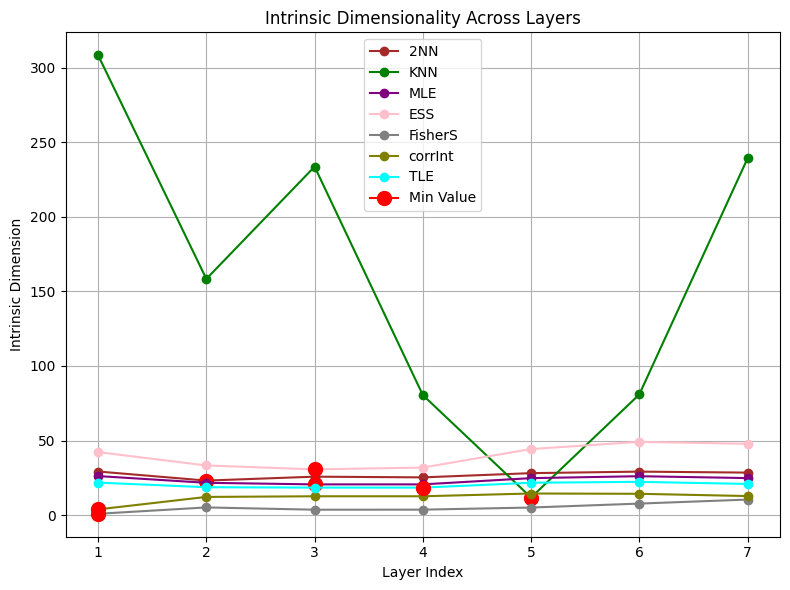

In [14]:
# Plot results
# Find the index of the minimum value
min_index_1 = mean_id_2NN.index(min(mean_id_2NN)) + 1
min_index_2 = mean_id_knn.index(min(mean_id_knn)) + 1
min_index_3 = mean_id_mle.index(min(mean_id_mle)) + 1
min_index_4 = mean_id_ess.index(min(mean_id_ess)) + 1
min_index_5 = mean_id_fs.index(min(mean_id_fs)) + 1
min_index_6 = mean_id_corrInt.index(min(mean_id_corrInt)) + 1
min_index_7 = mean_id_tle.index(min(mean_id_tle)) + 1


# Plot results
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 8), mean_id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
plt.plot(min_index_1, min(mean_id_2NN), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_knn, marker='o', linestyle='-', label='KNN',color='green')
plt.plot(min_index_2, min(mean_id_knn), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_mle, marker='o', linestyle='-', label='MLE',color='purple')
plt.plot(min_index_3, min(mean_id_mle), marker='o', color='red', markersize=10)


plt.plot(np.arange(1, 8), mean_id_ess, marker='o', linestyle='-', label='ESS',color='pink')
plt.plot(min_index_4, min(mean_id_ess), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
plt.plot(min_index_5, min(mean_id_fs), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
plt.plot(min_index_6, min(mean_id_corrInt), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
plt.plot(min_index_7, min(mean_id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 8))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()

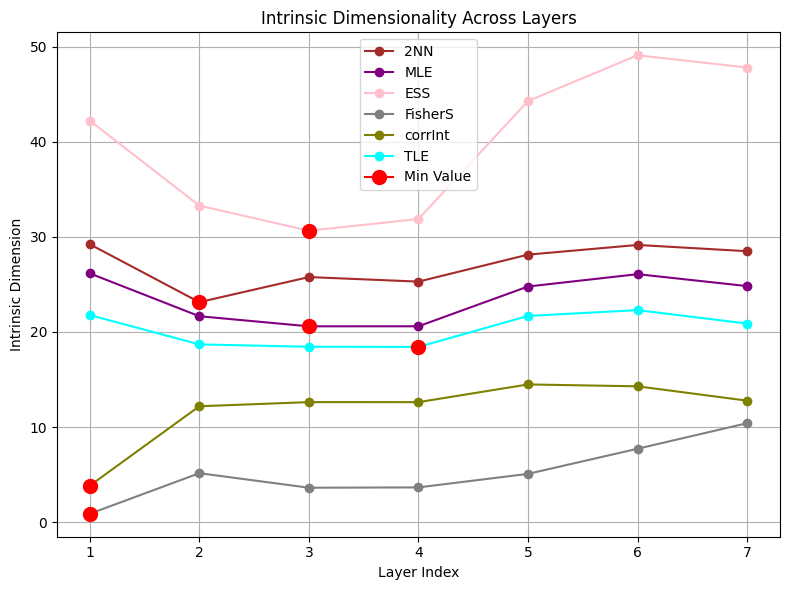

In [15]:
# Plot results
# Find the index of the minimum value
min_index_1 = mean_id_2NN.index(min(mean_id_2NN)) + 1
min_index_2 = mean_id_knn.index(min(mean_id_knn)) + 1
min_index_3 = mean_id_mle.index(min(mean_id_mle)) + 1
min_index_4 = mean_id_ess.index(min(mean_id_ess)) + 1
min_index_5 = mean_id_fs.index(min(mean_id_fs)) + 1
min_index_6 = mean_id_corrInt.index(min(mean_id_corrInt)) + 1
min_index_7 = mean_id_tle.index(min(mean_id_tle)) + 1


# Plot results
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 8), mean_id_2NN, marker='o', linestyle='-', label='2NN',color='brown')
plt.plot(min_index_1, min(mean_id_2NN), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_mle, marker='o', linestyle='-', label='MLE',color='purple')
plt.plot(min_index_3, min(mean_id_mle), marker='o', color='red', markersize=10)


plt.plot(np.arange(1, 8), mean_id_ess, marker='o', linestyle='-', label='ESS',color='pink')
plt.plot(min_index_4, min(mean_id_ess), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_fs, marker='o', linestyle='-', label='FisherS',color='gray')
plt.plot(min_index_5, min(mean_id_fs), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_corrInt, marker='o', linestyle='-', label='corrInt',color='olive')
plt.plot(min_index_6, min(mean_id_corrInt), marker='o', color='red', markersize=10)

plt.plot(np.arange(1, 8), mean_id_tle, marker='o', linestyle='-', label='TLE',color='cyan')
plt.plot(min_index_7, min(mean_id_tle), marker='o', color='red', markersize=10, label='Min Value')

plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 8))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()